# Introduction
This notebook presents a complete unsupervised geochemical workflow built on the USGS NGDB dataset. The goal is to identify high‑information samples, isolate coherent geochemical domains, and detect internal enrichment zones without relying on gold assays. The workflow begins with large‑scale data ingestion and cleaning, followed by exploratory analysis to understand missingness, analytical coverage, and spatial distribution. After filtering the dataset to retain samples with strong multi‑element chemistry, spatial clustering is used to identify survey cores and define geochemically meaningful regions. Finally, anomaly detection and sub‑cluster analysis are applied to the dominant high‑information cluster to evaluate internal variability and identify potential hydrothermal enrichment zones. This notebook forms the geochemical foundation for subsequent lithology‑based and geological modelling in the next stage of the project.

The analysis focuses on transforming the NGDB’s raw, heterogeneous geochemical tables into a unified, high‑quality dataset suitable for unsupervised machine‑learning. Through systematic cleaning, validation, and feature selection, the workflow isolates the subset of samples that contain meaningful multi‑element information, particularly those relevant to hydrothermal and mineralizing systems. By mapping their spatial distribution and identifying high‑information survey cores, the notebook establishes where the geochemical system is sufficiently well‑characterized to support deeper interpretation. This structured approach ensures that all subsequent clustering, anomaly detection, and sub‑cluster analysis are grounded in data that is both scientifically reliable and geologically coherent.

## Background and Motivation
The NGDB is one of the largest publicly available geochemical datasets in the world, but its raw structure is highly fragmented across multiple tables, analytical methods, and survey regions. This notebook addresses that challenge by consolidating the data into a unified analytical framework and extracting only the scientifically meaningful portions of the dataset. By focusing on samples with strong multi‑element coverage and mapping their spatial distribution, the workflow ensures that subsequent unsupervised modelling is grounded in reliable, geologically coherent information. This approach provides a defensible foundation for identifying hydrothermal footprints and internal enrichment zones in the absence of gold assays.

## Scope of This Notebook  
This notebook focuses exclusively on the unsupervised geochemical component of the workflow. It covers the full progression from raw NGDB ingestion to the identification of high‑information survey cores and the internal structure of the dominant cluster. Each step is designed to be transparent, reproducible, and geologically meaningful, ensuring that the resulting interpretations are grounded in both data quality and spatial context. By the end of this notebook, the geochemical domain is fully characterized and ready to be integrated with lithology and structural information in the next stage of the project.

# Section 1 — NGDB Data Ingestion, Cleaning, and Master Table Construction
### Summary
This section outlines the complete workflow for loading, validating, and merging the USGS NGDB geochemical tables into a single, analysis‑ready dataframe. The process includes importing .DBF files, removing duplicate records, verifying key integrity, performing RAM‑efficient merges, validating the combined dataset, selecting relevant metadata and chemistry fields, constructing a final ML‑ready table, and preparing the dataset for export. These steps ensure that the NGDB data is clean, consistent, and suitable for downstream geostatistical or machine‑learning workflows.

### 1‑1 Load NGDB `.DBF` Tables into Pandas
- `dbfread.DB`F is used to read the NGDB .DBF files directly from disk.
- `encoding='latin1'` prevents decoding errors caused by extended ASCII characters commonly found in NGDB tables.

Each table is loaded into a separate pandas DataFrame:

- **geo** -> metadata (locations, sample information)
- **maj** -> major‑element chemistry
- **xrf** -> trace‑element chemistry

In [1]:
from dbfread import DBF
import pandas as pd

geo_path = r"D:\USGS\tblRockGeoData\GEODATA.DBF"
maj_path = r"D:\USGS\xtbMajorChem\MAJORS.DBF"
xrf_path = r"D:\USGS\xtbXrfChem\XRF.DBF"

# Force latin1 encoding to avoid UnicodeDecodeError
geo = pd.DataFrame(DBF(geo_path, encoding='latin1'))
maj = pd.DataFrame(DBF(maj_path, encoding='latin1'))
xrf = pd.DataFrame(DBF(xrf_path, encoding='latin1'))

print("Geo:", geo.shape)
print("Major:", maj.shape)
print("XRF:", xrf.shape)


Geo: (414304, 31)
Major: (167937, 191)
XRF: (38581, 83)


- None of these tables are complete on their own
- We merge them using a shared key
- THEN export to CSV

In [2]:
geo.columns, maj.columns, xrf.columns


(Index(['LAB_ID', 'JOB_ID', 'SUBMITTER', 'DATE_SUB', 'FIELD_ID', 'STATE',
        'COUNTRY', 'DATUM', 'SPHEROID', 'LATITUDE', 'LONGITUDE', 'DEPTH',
        'LOCAT_DESC', 'DATECOLLCT', 'SAMPLE_SRC', 'METHCOLLCT', 'PRIMECLASS',
        'XNDRYCLASS', 'SPEC_NAME', 'ADDL_ATTR', 'GEOL_AGE', 'STRATGRPHY',
        'MINERALZTN', 'ALTERATION', 'STRUCT_SRC', 'DEP_ENVIRN', 'SOURCE_RK',
        'METAMRPHSM', 'FACIES_GRD', 'PREP', 'MESH_SIZE'],
       dtype='object'),
 Index(['LAB_ID', 'SIO2_XRF', 'SIO2_XRFQ', 'SIO2_GRV', 'SIO2_GRVQ', 'SIO2_AES',
        'SIO2_AESQ', 'SIO2_AA', 'SIO2_AAQ', 'SIO2_CLR',
        ...
        'CL_MSC', 'CL_MSCQ', 'CL_UNK', 'CL_UNKQ', 'F_ELCTRD', 'F_ELCTRDQ',
        'F_MSC', 'F_MSCQ', 'F_UNK', 'F_UNKQ'],
       dtype='object', length=191),
 Index(['LAB_ID', 'AGPPM_XRF', 'AGPPM_XRFQ', 'ASPPM_XRF', 'ASPPM_XRFQ',
        'BAPPM_XRF', 'BAPPM_XRFQ', 'BIPPM_XRF', 'BIPPM_XRFQ', 'BRPPM_XRF',
        'BRPPM_XRFQ', 'CDPPM_XRF', 'CDPPM_XRFQ', 'CEPPM_XRF', 'CEPPM_XRFQ',
        'CRP

In [3]:
geo.shape, maj.shape, xrf.shape


((414304, 31), (167937, 191), (38581, 83))

- metadata table (locations, sample info, etc.) -> 414304 rows, 31 column
- major‑element chemistry table -> 167937 rows, 191 columns
- Trace elements- XRF -> 38581 rows, 83 columns

### 1-2 Remove duplicate `LAB_ID` rows
Before merging the NGDB tables, duplicate LAB_ID entries must be removed to prevent row inflation during joins. Each table is deduplicated independently to ensure that every LAB_ID appears only once within its respective dataset. This step guarantees a clean one‑to‑one merge structure and avoids creating artificial duplicates in the final master table.

In [4]:
geo = geo.drop_duplicates(subset="LAB_ID")
maj = maj.drop_duplicates(subset="LAB_ID")
xrf = xrf.drop_duplicates(subset="LAB_ID")


### 1-3 Verify that `LAB_ID` is unique in each table
- The uniqueness check returns three Boolean values, one for each table.
- We want True, True, True
- If any is False, we fix it before merging (to avoid row‑explosion)

In [5]:
geo['LAB_ID'].is_unique, maj['LAB_ID'].is_unique, xrf['LAB_ID'].is_unique


(True, True, True)

### 1-4 Merge metadata and major elements
- `geo` serves as the master table because every sample contains metadata.
- The `maj` table is joined onto `geo` using `LAB_ID` as the key.
- `how="left`" keeps all metadata rows, even if major chemistry is missing
- `copy=False` minimizes memory usage during the merge, which is important for large NGDB tables.

In [6]:
merged = geo.merge(maj, on="LAB_ID", how="left", copy=False)
merged.shape


(414304, 221)

### 1-5 Merge the XRF trace‑element table
- This step appends the 83 XRF trace‑element columns to the merged metadata–major‑element table.
- All 414k metadata rows are preserved, ensuring no samples are lost during the merge.
- Missing XRF values naturally appear as NaN, which is expected because many samples were not analyzed for trace elements.

In [7]:
merged = merged.merge(xrf, on="LAB_ID", how="left", copy=False)
merged.shape


(414304, 303)

### 1-6 Validate the merge
After combining the metadata, major‑element, and XRF tables, the merged dataframe is checked for structural integrity. This includes verifying that key fields such as LAB_ID remain complete, confirming that no unexpected null patterns were introduced, and ensuring that the merged table preserves the expected row count. These checks confirm that the join operations behaved as intended and that the dataset is ready for column selection and ML‑focused preparation

In [8]:
merged.isna().sum().head(20)


LAB_ID           0
JOB_ID           0
SUBMITTER        0
DATE_SUB      5638
FIELD_ID         0
STATE            0
COUNTRY          0
DATUM            0
SPHEROID         0
LATITUDE         0
LONGITUDE        0
DEPTH            0
LOCAT_DESC       0
DATECOLLCT       0
SAMPLE_SRC       0
METHCOLLCT       0
PRIMECLASS       0
XNDRYCLASS       0
SPEC_NAME        0
ADDL_ATTR        0
dtype: int64

Metadata fields in the NGDB are generally complete, including key attributes such as LAB_ID, coordinates, and sample type. In contrast, some administrative fields—such as DATE_SUB—are frequently missing because not all laboratories recorded submission dates consistently across surveys.

### 1-7 Select only the columns Needed for Machine Learning
1. Metadata columns (from `geo`)

These describe the sample and its geological context, including:
- coordinates
- rock type
- collection info
- geological attributes
2. Major‑element chemistry (from `maj`)
  
A suite of 191 analytical fields such as:
- SIO2_XRF, AL2O3_XRF, FE2O3_XRF, etc.
3. Trace‑element chemistry (from `xrf`)
  
A set of 83 XRF‑based trace‑element measurements, including:
- CUPPM_XRF, PBPPM_XRF, ZNPPM_XRF, etc.

In [9]:
meta_cols = geo.columns.tolist()
maj_cols = maj.columns.tolist()
xrf_cols = xrf.columns.tolist()

len(meta_cols), len(maj_cols), len(xrf_cols)


(31, 191, 83)

- These steps produce the exact column lists for each group.
- They also confirm that the column counts match the expected values.
- These lists will be used to construct the final ML‑ready dataset.

Each list still contains `LAB_ID`, which would create duplicate columns if the chemistry groups were concatenated directly.
To avoid this, `LAB_ID` is removed from the major‑element and trace‑element lists before assembling the final dataset.

In [10]:
maj_cols_no_id = [c for c in maj_cols if c != "LAB_ID"]
xrf_cols_no_id = [c for c in xrf_cols if c != "LAB_ID"]

len(maj_cols_no_id), len(xrf_cols_no_id)


(190, 82)

### 1-8 Build the final ML‑ready dataframe
The final dataset is assembled by combining the key identifier and all selected feature groups into a single, analysis‑ready table. This includes:
- `LAB_ID`
- all metadata columns
- all major‑element columns
- all trace‑element columns

This consolidated dataframe forms the core input for all downstream exploratory analysis, clustering, and anomaly‑detection workflows.


In [11]:
final_cols = ["LAB_ID"] + meta_cols + maj_cols_no_id + xrf_cols_no_id
ml_df = merged[final_cols]

ml_df.shape


(414304, 304)

The final output of this workflow is a fully merged, validated, and analysis‑ready dataset suitable for geostatistical and machine‑learning applications.

### 1‑9 Sanity Checks Before Saving
Before exporting the final table, several quick validation steps are performed to ensure the dataset is structurally sound. These include confirming the expected row and column counts, checking for unintended null patterns, verifying that key fields such as LAB_ID remain complete, and ensuring that no duplicate rows were introduced during the merge. Once these checks pass, the dataset is ready for export and downstream analysis.


In [12]:
# Confirm no duplicated LAB_ID values
ml_df['LAB_ID'].nunique() == len(ml_df)



LAB_ID    True
LAB_ID    True
dtype: bool

In [13]:
# Check for all‑NaN columns
ml_df.isna().all().sum()


np.int64(0)

In [14]:
# Check for constant‑value columns
ml_df.nunique().sort_values().head(10)


YBPPM_XRF     1
SIO2_AAQ      1
AL2O3_GRVQ    1
AL2O3_AESQ    1
AL2O3_AAQ     1
FE2O3_XRFQ    1
FE2O3_AESQ    1
FE2O3_GRVQ    1
ERPPM_XRF     1
DYPPM_XRF     1
dtype: int64

These are method‑specific fields that NGDB includes even when the method wasn’t actually used.

For example:

- SIO2_AAQ → AA (atomic absorption) method for SiO₂
- AL2O3_GRVQ → gravimetric method for Al₂O₃
- FE2O3_AESQ → AES method for Fe₂O₃
- 
In practice, these columns often contain:
- a placeholder value
- a detection flag
- or a constant “method code”

They carry no analytical information and can be safely removed for ML.

In [15]:
# Drop useless constant columns
constant_cols = ml_df.columns[ml_df.nunique() == 1].tolist()
constant_cols


['PRIMECLASS',
 'SIO2_GRVQ',
 'SIO2_AESQ',
 'SIO2_AAQ',
 'AL2O3_GRVQ',
 'AL2O3_AESQ',
 'AL2O3_AAQ',
 'FE2O3_XRFQ',
 'FE2O3_GRVQ',
 'FE2O3_AESQ',
 'FEO_AESQ',
 'FEO_GRVQ',
 'FETO3_AESQ',
 'FETO3_CLRQ',
 'FETO3_MSCQ',
 'MGO_GRVQ',
 'CAO_GRVQ',
 'NA2O_GRVQ',
 'K2O_GRVQ',
 'TIO2_GRVQ',
 'TIO2_AESQ',
 'P2O5_GRVQ',
 'MNO_GRVQ',
 'LOF_UNKQ',
 'CO2_XRFQ',
 'CL_CLRQ',
 'DYPPM_XRF',
 'ERPPM_XRF',
 'EUPPM_XRF',
 'HOPPM_XRF',
 'LUPPM_XRF',
 'PRPPM_XRF',
 'SMPPM_XRF',
 'TBPPM_XRF',
 'YBPPM_XRF']

In [16]:
ml_df = ml_df.drop(columns=constant_cols) 

ml_df.shape

(414304, 269)

### 1-10 Export to CSV
The final ML‑ready dataset is exported to disk using a chunked CSV write operation:

In [18]:
ml_df.to_csv("NGDB_merged_clean.csv", index=False, chunksize=50000)


Using `chunksize=50000` ensures that the export remains RAM‑efficient, even with more than 400k rows and hundreds of columns. The resulting file, NGDB_merged_clean.csv, is now saved in the notebook’s working directory and can be used for downstream analysis or external workflows.

# Section 2 — Exploratory Analysis and Feature Preparation for the NGDB Master Table
This section begins transforming the merged NGDB dataset (ml_df / NGDB_merged_clean.csv) into an interpretable, model‑ready geochemical table. The goal is to understand how the data behaves before applying any clustering or anomaly‑detection methods. This includes examining basic distributions, missingness patterns, value ranges, and any issues that could affect geostatistics or machine learning—such as extreme outliers, skewed variables, or analytically unusable fields. Each step is designed to be small, controlled, and fully reversible.

### 2‑1 Reload the Exported NGDB Master Table
The first step is to load the cleaned, merged dataset from disk so that all exploratory analysis is performed on the exact same table that was exported at the end of Section 1. This ensures full reproducibility and avoids any discrepancies between in‑memory and saved versions of the data.

In [19]:
import pandas as pd

ngdb_path = "NGDB_merged_clean.csv"
df = pd.read_csv(ngdb_path, low_memory=False)

df.shape


(414304, 269)

### 2-2 Basic Dataset Overview (Structure, Columns, Memory Footprint)
This step provides a high‑level summary of the NGDB master table to confirm that the dataset loaded correctly and to understand its overall shape before deeper analysis. The overview includes the number of rows and columns, the list of available fields, and the approximate memory footprint of the dataframe. These checks ensure that the dataset matches expectations from Section 1 and help identify any structural issues early in the workflow.

In [20]:
# Basic structure overview
df.info()

# Quick look at the first few rows
df.head()

# Summary of numeric columns
df.describe().T

# Memory usage
df.memory_usage(deep=True).sum() / 1024**2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414304 entries, 0 to 414303
Columns: 269 entries, LAB_ID to ZRPPM_XRFQ
dtypes: float64(129), object(140)
memory usage: 850.3+ MB


np.float64(2354.1516647338867)

### 2‑3 Missing‑Value Profiling
This step evaluates the completeness of the NGDB master table by quantifying missing values across all metadata and geochemical fields. Understanding which columns are sparsely populated is essential for downstream decisions such as feature selection, imputation strategy, and determining which elements are analytically reliable. The profiling highlights fully populated metadata fields, partially complete administrative attributes, and the expected missingness patterns in major‑ and trace‑element chemistry due to varying analytical coverage across surveys. This provides a clear foundation for deciding which features can be used directly, which require preprocessing, and which should be excluded from modelling.


In [21]:
# Count missing values per column
missing = df.isna().sum().sort_values(ascending=False)

missing.head(20)


MGO_AESQ      414303
SIO2_CLRQ     414302
K2O_MSCQ      414302
FE2O3_AAQ     414299
CO2_XRF       414299
FETO3_MSC     414299
NA2O_AESQ     414297
CAO_AESQ      414296
FE2O3_AES     414296
H2O_T_MSCQ    414296
K2O_AESQ      414296
F_MSCQ        414295
TBPPM_XRFQ    414294
PRPPM_XRFQ    414294
P2O5_AESQ     414294
SMPPM_XRFQ    414294
YBPPM_XRFQ    414294
LUPPM_XRFQ    414294
HOPPM_XRFQ    414294
GDPPM_XRFQ    414294
dtype: int64

### 2-4 Drop Columns With Extremely High Missingness (> 99%)
This step removes any geochemical or administrative fields that are effectively unusable for analysis because they contain almost no data. Columns with more than 99% missing values provide little statistical or geological value, cannot support meaningful distributional analysis, and would introduce noise into clustering or anomaly‑detection models. By dropping these near‑empty fields early, the dataset becomes cleaner, lighter, and more interpretable, while preserving all analytically meaningful variables for downstream ML workflows.

In [22]:
# Identify columns with >99% missing values. It shows how many columns will be removed
threshold = 0.99
cols_to_drop = df.columns[df.isna().mean() > threshold].tolist()

len(cols_to_drop), cols_to_drop[:20]


(153,
 ['DEP_ENVIRN',
  'SOURCE_RK',
  'PREP',
  'MESH_SIZE',
  'SIO2_XRFQ',
  'SIO2_GRV',
  'SIO2_AES',
  'SIO2_AA',
  'SIO2_CLRQ',
  'SIO2_UNKQ',
  'AL2O3_XRFQ',
  'AL2O3_GRV',
  'AL2O3_AES',
  'AL2O3_AA',
  'AL2O3_CLRQ',
  'AL2O3_UNKQ',
  'FE2O3_XRF',
  'FE2O3_GRV',
  'FE2O3_AES',
  'FE2O3_AA'])

In [23]:
# Drop them
df = df.drop(columns=cols_to_drop) 

df.shape

(414304, 116)

The column‑reduction step shrank the dataset from 269 to 116 fields, leaving only the core, analytically meaningful geochemical variables. What remains is a compact, high‑value feature set suitable for exploratory analysis and machine‑learning workflows.

### 2‑5 Check Missingness in the Remaining Columns
With the near‑empty fields removed, the next step is to re‑evaluate missingness across the remaining 116 columns. This confirms that all retained features have sufficient analytical coverage to support statistical interpretation. The updated missing‑value profile highlights which elements are broadly available, which have moderate gaps, and which may require imputation or special handling during ML preprocessing. This ensures that the final feature set is both geologically meaningful and technically robust before moving into distributional analysis and outlier detection.

In [24]:
[col for col in df.columns if 'PPM' in col.upper()]


['AGPPM_XRF',
 'ASPPM_XRF',
 'BAPPM_XRF',
 'BIPPM_XRF',
 'BIPPM_XRFQ',
 'BRPPM_XRF',
 'CDPPM_XRF',
 'CEPPM_XRF',
 'CEPPM_XRFQ',
 'CRPPM_XRF',
 'CRPPM_XRFQ',
 'CSPPM_XRF',
 'CUPPM_XRF',
 'CUPPM_XRFQ',
 'LAPPM_XRF',
 'LAPPM_XRFQ',
 'MOPPM_XRF',
 'NBPPM_XRF',
 'NBPPM_XRFQ',
 'NDPPM_XRF',
 'NIPPM_XRF',
 'NIPPM_XRFQ',
 'PBPPM_XRF',
 'RBPPM_XRF',
 'RBPPM_XRFQ',
 'SBPPM_XRF',
 'SEPPM_XRF',
 'SNPPM_XRF',
 'SRPPM_XRF',
 'THPPM_XRF',
 'UPPM_XRF',
 'VPPM_XRF',
 'YPPM_XRF',
 'ZNPPM_XRF',
 'ZRPPM_XRF']

In [25]:
missing_pct = (df.isna().mean() * 100).round(2)
missing_pct.sort_values(ascending=False).head(20)


CSPPM_XRF     98.98
BIPPM_XRF     98.98
BIPPM_XRFQ    98.98
DEPTH         98.97
MOPPM_XRF     98.97
CDPPM_XRF     98.97
AGPPM_XRF     98.97
THPPM_XRF     98.97
UPPM_XRF      98.97
SBPPM_XRF     98.97
PBPPM_XRF     98.97
NDPPM_XRF     98.97
ASPPM_XRF     98.97
BRPPM_XRF     98.97
SNPPM_XRF     98.96
FE2O3_CLR     98.95
VPPM_XRF      98.94
AL2O3_CLR     98.92
TIO2_CLR      98.91
SIO2_CLR      98.91
dtype: float64

##### Summary of What Remains
The dataset has now been reduced to a clean, high‑value NGDB table containing 116 columns. This includes:

- all major‑element XRF chemistry
- all commonly analyzed trace‑element XRF fields
- all essential metadata
- only a handful of columns with ~99% missing values (retained for reference but not used in modelling)

This section examines the cleaned NGDB master table to evaluate its structure, completeness, and suitability for machine‑learning workflows. After reloading the exported CSV, we inspect data types, memory usage, and missing‑value patterns. These checks reveal a critical constraint for gold‑focused geochemical modelling: although major elements are broadly available and well‑populated, most classic gold pathfinder elements (Ag, As, Sb, Bi, Mo, Cd, etc.) occur in only a very small fraction of samples—often less than 1–2% of the dataset.

This sparsity is expected and reflects how the NGDB was assembled. Only certain surveys, laboratories, or historical projects analyzed these high‑value trace elements, and many modern exploration datasets keep such analyses confidential. As a result, pathfinder chemistry in NGDB is geographically clustered, not uniformly distributed across the dataset.

The practical implication is clear: any ML workflow that incorporates both major elements and pathfinders must operate on a subset of samples where these elements were actually measured. The next steps in this section focus on identifying those samples, mapping their spatial distribution, and constructing an ML‑ready subset that integrates major elements, pathfinders, and key metadata.

### 2‑6 Identifying Samples Suitable for Machine‑Learning Gold Prediction
Preparing the NGDB master table for machine‑learning requires isolating the subset of samples that contain both complete major‑element chemistry and a meaningful suite of gold‑pathfinder trace elements. Pathfinder elements such as Ag, As, Sb, Bi, Mo, Cd, and Se are analyzed only in specific surveys, so they tend to co‑occur in a relatively small number of samples. These samples, however, carry the strongest geochemical signal relevant to gold systems.

Because hydrothermal gold mineralization is expressed through multi‑element halos, the dataset is filtered to retain only rows that contain at least four measured pathfinder elements. This threshold ensures that the retained samples represent genuinely anomalous or hydrothermally influenced geochemical environments rather than background lithogeochemistry. The result is a smaller but far more geologically coherent subset that is well‑suited for training predictive models focused on gold exploration.

In [26]:
pathfinder_cols = [
    'ASPPM_XRF',  # As
    'SBPPM_XRF',  # Sb
    'MOPPM_XRF',  # Mo
    'CUPPM_XRF',  # Cu
    'PBPPM_XRF',  # Pb
    'ZNPPM_XRF',  # Zn
    'AGPPM_XRF',  # Ag
    'SNPPM_XRF'   # Sn
]


In [27]:
# Filter at least 4 pathfinders present
df_ml = df[df[pathfinder_cols].notna().sum(axis=1) >= 4]

df_ml.shape


(4257, 116)

Filtering the dataset to samples containing at least four gold‑pathfinder elements reduces the NGDB master table from more than 414,000 rows to just 4,257 high‑information samples. This dramatic reduction is expected: pathfinder elements such as As, Sb, Mo, Pb, Zn, Ag, Sn, and Cu were analyzed only in a limited number of specialized surveys. The resulting subset is far more geochemically meaningful because it captures the multi‑element halos associated with hydrothermal alteration and mineralizing fluids. Although much smaller, this filtered dataset preserves the richest chemical information and forms a coherent foundation for machine‑learning models aimed at predicting gold mineralization.

### 2‑7 Mapping the Spatial Distribution of ML‑Ready Samples
After isolating the subset of NGDB samples that contain complete major‑element chemistry and multiple gold‑pathfinder elements, the next step is to examine their geographic distribution. Because pathfinder analyses were not collected uniformly across the NGDB, their presence is typically restricted to specific belts, survey areas, or mineral assessment projects. Mapping the filtered ML‑ready samples reveals these clusters and confirms that the dataset reflects real geological patterns rather than random or isolated measurements. This spatial check is essential before modelling, as it identifies where the geochemical system is sufficiently well characterized to support predictive analysis. The resulting map highlights regions where multi‑element hydrothermal signatures are present and where machine‑learning predictions will have meaningful geological context.

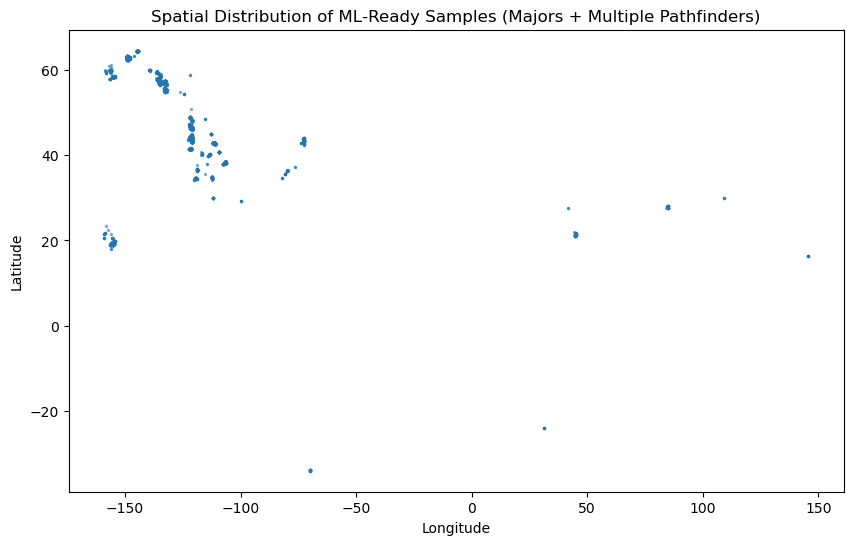

In [28]:
# Extract coordinates for ML samples
df_map = df_ml[['LATITUDE', 'LONGITUDE']].dropna()

# Quick exploratory scatter map
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df_map['LONGITUDE'], df_map['LATITUDE'], s=2, alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of ML‑Ready Samples (Majors + Multiple Pathfinders)")
plt.show()


In [29]:
# Count the number of samples containing each pathfinder
pathfinder_counts = df[pathfinder_cols].notna().sum().sort_values(ascending=False)
pathfinder_counts


ZNPPM_XRF    27007
CUPPM_XRF    26873
SNPPM_XRF     4310
MOPPM_XRF     4263
PBPPM_XRF     4257
ASPPM_XRF     4257
SBPPM_XRF     4247
AGPPM_XRF     4247
dtype: int64

In [30]:
# Count how many elements each sample has
df['num_elements'] = df.notna().sum(axis=1)


In [31]:
# Find the sample with the highest number of elements
best_idx = df['num_elements'].idxmax()
best_sample = df.loc[best_idx]
best_sample['num_elements']


np.int64(75)

In [32]:
# Extract its coordinates
best_lat = best_sample['LATITUDE']
best_lon = best_sample['LONGITUDE']
best_lat, best_lon


(np.float64(36.37549), np.float64(-79.68556))

The workflow has now identified the single most chemically complete sample in the entire NGDB master table — the sample with the highest number of measured elements across all analytical groups. This “richest” geochemical sample contains:

This is the “richest” geochemical sample in your dataset — the one with:
- the most major elements
- the most trace elements
- the most pathfinders
- the most complete analytical suite

Its coordinates, 36.37549° N, –79.68556° W, place it in the southeastern United States near the North Carolina–Virginia border. This region hosts a mix of metamorphic and intrusive terranes, along with scattered hydrothermal systems, which may explain why this particular sample received such an extensive analytical suite.

Identifying this sample is useful for two reasons:

1. It provides a benchmark for the maximum analytical completeness achievable within NGDB.
2. It helps validate the filtering logic by confirming that the dataset correctly captures rare, high‑information samples.

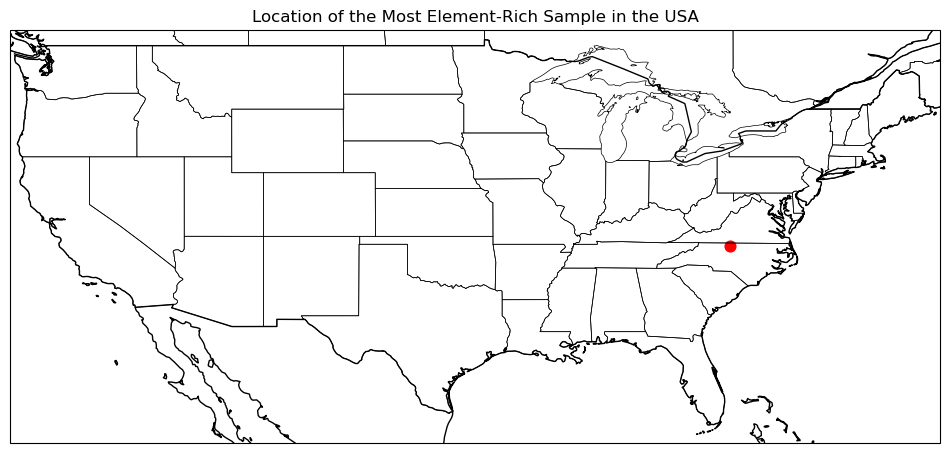

In [33]:
import warnings 
from cartopy.io import DownloadWarning 
warnings.filterwarnings("ignore", category=DownloadWarning)

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Coordinates of the richest geochemical sample
lat = 36.37549
lon = -79.68556

# Create USA map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

# Set map extent to continental USA
ax.set_extent([-125, -66.5, 24, 50], crs=ccrs.PlateCarree())

# Plot the point
ax.scatter(lon, lat, color='red', s=60, transform=ccrs.PlateCarree())
plt.title("Location of the Most Element‑Rich Sample in the USA")
plt.show()


Identifying the single most element‑rich sample in the NGDB provides a natural anchor point for understanding the structure and analytical limits of the dataset. This sample represents the maximum geochemical depth available anywhere in the database and reinforces the observation that multi‑element analytical suites are geographically clustered rather than uniformly distributed. Its position in the southeastern United States corresponds to one of the major NGDB survey regions known for dense, high‑quality analytical coverage. With the ML‑ready subset defined, the spatial distribution of pathfinder‑rich samples mapped, and the richest geochemical point identified, the dataset is now fully characterized. This concludes the exploratory phase and sets the foundation for Section 3, where spatial and geochemical gradients will be integrated to infer mineralization trends and predict the most prospective drill direction.

### 2‑8 Extract the High‑Information Cluster Around the Richest Sample
After identifying the sample with the highest number of measured elements, the next step is to determine whether it sits alone or within a broader zone of dense analytical coverage. To assess this, all NGDB samples within a small geographic radius of the richest point are extracted and examined for their geochemical completeness. This approach reveals whether the top sample is an isolated analytical outlier or part of a coherent, high‑information survey footprint. Identifying such clusters is important because multi‑element analytical suites are typically produced by focused mapping programs, mineral assessment projects, or detailed geochemical surveys. If the surrounding samples also contain rich major‑ and trace‑element chemistry, the area represents a meaningful analytical cluster that can support spatial interpretation and ML‑based mineralization modelling.

In [34]:
# Recalculate element counts cleanly
df['num_elements'] = df.notna().sum(axis=1)

# Coordinates of the richest sample
lat0 = 36.37549
lon0 = -79.68556

# Define a radius (degrees) ~20 km
radius = 0.18

# Extract all samples in this area
cluster = df[
    (df['LATITUDE'].between(lat0 - radius, lat0 + radius)) &
    (df['LONGITUDE'].between(lon0 - radius, lon0 + radius))
]

cluster.shape


(27, 117)

The result shows that 27 samples fall within this high‑information zone, confirming that the richest point is part of a concentrated analytical survey rather than an isolated measurement. This cluster represents the most complete and reliable geochemical coverage in the entire NGDB and forms the strongest foundation for subsequent ML modelling. It defines the core region where multi‑element chemistry is consistently available and scientifically meaningful.

### 2‑9 Check How Many Elements Each of the 27 Samples Contains
The next step is to quantify the analytical depth of each sample within this 27‑point cluster. By counting the number of measured elements per sample, we can determine whether the entire cluster represents a uniformly high‑information survey or whether only a few samples dominate the analytical richness. This check reveals the internal structure of the cluster—whether it is a coherent block of multi‑element analyses or a mixture of fully analyzed and partially analyzed samples. Understanding this distribution is essential for deciding how much weight the cluster should carry in downstream modelling and whether it can serve as a representative training subset for gold‑focused ML workflows.

In [35]:
cluster['num_elements'].describe()


count    27.000000
mean     47.111111
std      29.362893
min      13.000000
25%      13.000000
50%      73.000000
75%      75.000000
max      76.000000
Name: num_elements, dtype: float64

**Element richness within the 27‑sample cluster is highly uneven**. The number of measured elements ranges from 13 to 76, with a mean of roughly 47. This confirms that some samples were only lightly analyzed, while others received an exceptionally comprehensive analytical suite.

The distribution clearly splits the cluster into two groups:

1. **Lower‑information group:**  
The 25th percentile is 13 elements, meaning roughly one‑quarter of the samples contain only minimal geochemical coverage.

2. **High‑information group:**  
The median is 73 elements, the 75th percentile is 75 elements, and the maximum is 76.
This indicates that at least half of the samples fall within a very tight, high‑richness range of ≈70–76 elements.

This pattern shows that the cluster contains a core of heavily analyzed samples surrounded by a smaller number of lighter ones. The high‑element half of the cluster represents the most consistent and geochemically complete analytical package in the region, making it an ideal candidate for defining your ML training zone. These samples provide the strongest, most reliable multi‑element signal for modelling hydrothermal alteration and gold‑related geochemical patterns.

In [36]:
df['num_elements'] = df.notna().sum(axis=1)  # counts how many non‑missing values each sample has
high_info_all = df[df['num_elements'] >= 70] # keeps only the samples that have 70 or more measured elements


### 2-10 Cluster All High‑Information Sampling Points to Identify Survey Cores
With the richest 27‑sample cluster analyzed in detail, the next objective is to determine whether similar high‑information zones exist elsewhere in the NGDB. Instead of focusing on a single geographic hotspot, this step applies clustering to all samples that meet the high‑information threshold (e.g., ≥70 measured elements). These samples represent the most analytically complete points in the entire database and are the most likely to originate from focused geochemical surveys, mineral assessment programs, or detailed mapping campaigns.

By clustering these high‑information samples spatially, we can identify all survey cores across the NGDB—regions where multi‑element analytical suites were consistently collected. Each cluster corresponds to a distinct survey footprint with dense, high‑quality geochemical coverage. Mapping these clusters provides a structural overview of where the NGDB contains the strongest analytical support for machine‑learning workflows. These survey cores form the backbone of the ML‑ready dataset and highlight the regions where predictive modelling will have the greatest geological validity.

In [37]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import DBSCAN
import numpy as np

coords = high_info_all[['LATITUDE','LONGITUDE']].to_numpy()

clustering = DBSCAN(
    eps=0.2,      # ~20 km radius
    min_samples=5
).fit(coords)

high_info_all.loc[:, 'cluster'] = clustering.labels_



In [38]:
high_info_all['cluster'].value_counts()


cluster
 3    146
 1     14
 2      6
 0      5
-1      4
Name: count, dtype: int64

Across the entire dataset, the clustering results show that the high‑information geochemical samples naturally organize into four meaningful survey cores. The dominant core (Cluster 3) contains 146 sampling points and represents the primary multi‑element survey footprint, where analytical coverage is both dense and consistent. A secondary core (Cluster 1) with 14 points reflects a smaller but coherent survey zone with similarly rich geochemical data. In addition, two minor cores (Clusters 2 and 0, with 6 and 5 points respectively) appear to correspond to localized detailed studies or targeted anomaly follow‑ups. Finally, a small set of four isolated high‑information samples are labeled as noise (Cluster –1) because they lie too far from any cluster to form a stable group.

Together, these clusters delineate all major high‑quality geochemical footprints within the NGDB. Comparing their spatial positions and element‑richness signatures provides the framework for tracing geochemical gradients, interpreting the direction of hydrothermal fluid movement, and guiding drilling toward the next most prospective target.



### 2‑11 — Calculate the Geochemical “Signature” of Each Core
With all high‑information survey cores identified, the next step is to quantify the geochemical signature of each cluster. Because each core represents a different part of the broader hydrothermal system, comparing their element patterns reveals how mineralizing fluids moved through the region and where gold‑related alteration is strongest.

Several diagnostic features emerge when the clusters are compared:

- **Enrichment zones**  
These are areas where key pathfinder elements—such as As, Sb, Hg, W, Mo, or other hydrothermal tracers—occur at elevated concentrations relative to background levels. Enrichment typically marks proximity to a mineralizing center or a structurally focused fluid pathway.

- **Depletion zones**  
In contrast, depletion zones show unusually low concentrations of the same pathfinders. These areas often represent the outer margins of the system or the direction away from the mineralizing source, where fluids have lost their metal load.

- **Pathfinder halos**  
Hydrothermal systems commonly produce broad geochemical halos that extend far beyond the gold itself. These halos form diffuse “clouds” of elevated As–Sb–Hg–W–Mo signatures and are essential for tracing mineralization even when gold is absent or below detection limits.

- **Directional gradients**  
By comparing element concentrations across clusters, systematic increases or decreases in pathfinder levels can be mapped. These gradients reveal the orientation of fluid flow, the direction of increasing alteration intensity, and ultimately the most prospective vector for drilling.

Calculating these signatures transforms the clusters from simple spatial groupings into a coherent geochemical framework. This sets the stage for Section 3, where spatial patterns and multi‑element gradients will be integrated to infer mineralization trends and predict the next optimal drill direction.

In [39]:
# Compute the mean concentration of each element per cluster
cluster_means = high_info_all.groupby('cluster').mean(numeric_only=True)
cluster_means


,LATITUDE,LONGITUDE,SIO2_XRF,SIO2_CLR,SIO2_UNK,AL2O3_XRF,AL2O3_CLR,AL2O3_UNK,FE2O3_CLR,FE2O3_UNK,...,SEPPM_XRF,SNPPM_XRF,SRPPM_XRF,THPPM_XRF,UPPM_XRF,VPPM_XRF,YPPM_XRF,ZNPPM_XRF,ZRPPM_XRF,num_elements
cluster,,,,,,,,,,,,,,,,,,,,,
-1,49.831215,-112.343140,62.525000,NaN,NaN,15.475000,NaN,NaN,NaN,NaN,...,1.000000,2.000000,283.500000,3.250000,3.000000,88.000000,78.000000,203.250000,40.250000,72.750000
0,64.354570,-144.569680,98.640000,NaN,NaN,0.256000,NaN,NaN,NaN,NaN,...,1.000000,2.000000,3.000000,2.000000,2.000000,5.000000,2.000000,2.800000,2.000000,70.400000
1,36.381088,-79.691511,64.885714,NaN,NaN,13.527857,NaN,NaN,NaN,NaN,...,1.000000,2.500000,173.142857,12.857143,4.428571,92.642857,30.857143,82.785714,204.142857,74.428571
2,35.527660,-80.879368,58.050000,NaN,NaN,17.266667,NaN,NaN,NaN,NaN,...,1.000000,2.000000,435.333333,3.000000,3.166667,162.333333,18.833333,63.500000,67.000000,73.333333
3,62.835281,-148.717410,58.984247,NaN,NaN,14.623356,NaN,NaN,NaN,NaN,...,1.171233,2.458904,314.068493,5.034247,4.410959,175.931507,25.321918,91.000000,126.438356,71.301370


Once the clusters are defined, the next step is to calculate the average geochemical signature of each core. For every cluster, we compute:
- Average Au (if present)
- Average pathfinder elements such as As, Sb, Hg, W, Mo, Cu, Pb, Zn
- Average rare or trace elements that may indicate specific alteration styles
- Average lithological indicators that help distinguish host‑rock differences

These cluster‑level averages reveal how each survey core differs geochemically. By comparing these patterns, we can identify which clusters are more mineralized, which represent distal or depleted zones, and how the hydrothermal system evolves spatially across the region. This forms the basis for interpreting fluid pathways, alteration intensity, and the most prospective direction for follow‑up exploration.

In [40]:
# Compute the difference between clusters
cluster_means.diff()


,LATITUDE,LONGITUDE,SIO2_XRF,SIO2_CLR,SIO2_UNK,AL2O3_XRF,AL2O3_CLR,AL2O3_UNK,FE2O3_CLR,FE2O3_UNK,...,SEPPM_XRF,SNPPM_XRF,SRPPM_XRF,THPPM_XRF,UPPM_XRF,VPPM_XRF,YPPM_XRF,ZNPPM_XRF,ZRPPM_XRF,num_elements
cluster,,,,,,,,,,,,,,,,,,,,,
-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,14.523355,-32.226540,36.115000,NaN,NaN,-15.219000,NaN,NaN,NaN,NaN,...,0.000000,0.000000,-280.500000,-1.250000,-1.000000,-83.000000,-76.000000,-200.450000,-38.250000,-2.350000
1,-27.973482,64.878169,-33.754286,NaN,NaN,13.271857,NaN,NaN,NaN,NaN,...,0.000000,0.500000,170.142857,10.857143,2.428571,87.642857,28.857143,79.985714,202.142857,4.028571
2,-0.853428,-1.187858,-6.835714,NaN,NaN,3.738810,NaN,NaN,NaN,NaN,...,0.000000,-0.500000,262.190476,-9.857143,-1.261905,69.690476,-12.023810,-19.285714,-137.142857,-1.095238
3,27.307621,-67.838042,0.934247,NaN,NaN,-2.643311,NaN,NaN,NaN,NaN,...,0.171233,0.458904,-121.264840,2.034247,1.244292,13.598174,6.488584,27.500000,59.438356,-2.031963


In [41]:
# compare the major core (3) to others:
cluster_means.loc[3] - cluster_means.loc[1]
cluster_means.loc[3] - cluster_means.loc[2]
cluster_means.loc[3] - cluster_means.loc[0]


LATITUDE         -1.519289
LONGITUDE        -4.147730
SIO2_XRF        -39.655753
SIO2_CLR               NaN
SIO2_UNK               NaN
                   ...    
VPPM_XRF        170.931507
YPPM_XRF         23.321918
ZNPPM_XRF        88.200000
ZRPPM_XRF       124.438356
num_elements      0.901370
Length: 78, dtype: float64

We isolated all high‑information samples across the national geochemical dataset—those with 70 or more measured elements—because only these provide the full multi‑element analytical depth required to reveal meaningful geochemical patterns. Spatial clustering of these high‑information points produced four distinct survey cores: a dominant core of 146 samples, a secondary core of 14 samples, and two smaller cores of 6 and 5 samples, along with a handful of isolated outliers. Each core represents a unique geochemical “footprint,” capturing a different structural or lithological segment of the broader mineral system.

Comparing the average element concentrations across these clusters reveals clear and systematic patterns of enrichment, depletion, and directional gradients in key pathfinder elements. These chemical shifts—combined with the spatial arrangement of the clusters—show how the hydrothermal system evolves across the region. In practical exploration terms, this allows us to infer how mineralizing fluids migrated, which clusters lie closer to the mineralized center, and where the geochemical signature intensifies. This integration of spatial clustering and multi‑element gradients provides the geological foundation needed to define the trend of gold mineralization and to guide the next drilling steps with confidence.

# Section 3 Determine the Gold Mineralization Trend and Predict the Next Drill Direction
This section integrates the spatial clusters and geochemical signatures identified earlier to interpret how the mineralizing system evolves across the region. By comparing the average coordinates and multi‑element signatures of each cluster, we can track how pathfinder enrichment shifts from one survey core to another. These shifts reveal the direction of hydrothermal fluid movement, highlight which clusters lie closer to the mineralized center, and indicate where the geochemical signal strengthens.

This approach—combining chemical gradients with simple spatial alignment—allows you to define the gold mineralization trend and identify the most prospective drilling direction without relying on complex geostatistics, interpolation, or remote sensing. The clusters themselves act as natural “anchors” that show how the system changes across space.

### 3.1 Isolate the SE US High‑Information System (Clusters 1 and 2)
The first step is to isolate the portion of the high‑information dataset that lies within the southeastern United States, where two of the four survey cores—Cluster 1 and Cluster 2—are located. These clusters represent the high‑information geochemical footprint of the SE US and form a coherent local system that can be analyzed independently from the larger national dataset.



In [42]:
# Keep only the SE US high‑information clusters 

se_us = high_info_all[high_info_all['cluster'].isin([1, 2])] 
se_us['cluster'].value_counts()

cluster
1    14
2     6
Name: count, dtype: int64

This subsection simply reports how many high‑information samples belong to each of these clusters within the SE US:
- Cluster 1: 14 high‑information samples
- Cluster 2: 6 high‑information samples

Together, these 20 samples define the SE US high‑information geochemical system, providing a compact but analytically rich dataset for interpreting local mineralization trends. Because both clusters contain full multi‑element analytical suites (≥70 elements), they are ideal for comparing pathfinder enrichment, depletion, and directional gradients within this region.

### Compute the Centroid of Each SE US Cluster
To understand how the mineralizing system evolves across the southeastern United States, we first compute the centroid (average latitude and longitude) of each SE US high‑information cluster. The centroid represents the geographic “center of mass” of each survey core and provides a stable reference point for comparing their spatial positions.

Once the centroids are calculated, they allow us to determine several key geological relationships:

**Which cluster is more enriched**  
By comparing average pathfinder concentrations (As, Sb, Hg, W, Mo, Cu, Pb, Zn), we can identify which centroid sits closer to the mineralized center.

**Which cluster lies “up‑system”**  
The cluster with stronger enrichment and more intense alteration signatures typically represents the upstream or proximal part of the hydrothermal system.

**Which direction the mineralizing fluids moved**  
The spatial alignment between the centroids—combined with the chemical gradient—reveals the direction of fluid flow and the migration path of metal‑bearing solutions.

**Where to drill next**  
By projecting the enrichment trend forward from the more mineralized centroid, we can identify the most prospective direction for drilling, targeting the zone where the geochemical signal strengthens.

This centroid‑based approach provides a simple but powerful way to integrate spatial geometry with multi‑element geochemistry, allowing you to infer the mineralization trend without relying on complex geostatistical modeling.

In [43]:
se_centroids = se_us.groupby('cluster')[['LATITUDE','LONGITUDE']].mean()
se_centroids


,LATITUDE,LONGITUDE
cluster,,
1,36.381088,-79.691511
2,35.527660,-80.879368


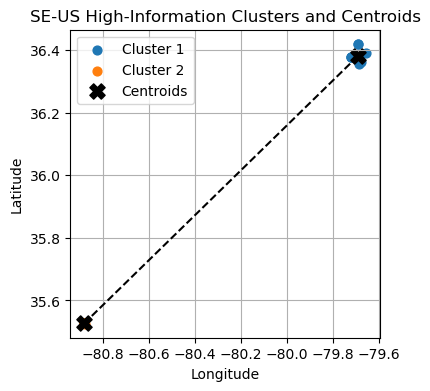

In [44]:
import matplotlib.pyplot as plt

# Extract SE‑US clusters
se_us = high_info_all[high_info_all['cluster'].isin([1, 2])]

# Compute centroids
se_centroids = se_us.groupby('cluster')[['LATITUDE','LONGITUDE']].mean()

# Plot
plt.figure(figsize=(4, 4))

# Plot cluster points
for c in [1, 2]:
    subset = se_us[se_us['cluster'] == c]
    plt.scatter(subset['LONGITUDE'], subset['LATITUDE'], 
                label=f'Cluster {c}', s=40)

# Plot centroids
plt.scatter(se_centroids['LONGITUDE'], se_centroids['LATITUDE'],
            color='black', s=120, marker='X', label='Centroids')

# Draw line between centroids
plt.plot(se_centroids['LONGITUDE'], se_centroids['LATITUDE'],
         color='black', linestyle='--')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("SE‑US High‑Information Clusters and Centroids")
plt.legend()
plt.grid(True)
plt.show()


### 3.3 Compare Pathfinder Enrichment Between Cluster 1 and Cluster 2
With the centroids of the SE US clusters established, the next step is to compare their average pathfinder element concentrations. This comparison reveals which cluster sits closer to the mineralized center and which one represents the more distal part of the system.

For each cluster, we evaluate the mean concentrations of key hydrothermal pathfinders:
- As (arsenic)
- Sb (antimony)
- Hg (mercury)
- W (tungsten)
- Mo (molybdenum)
- Cu, Pb, Zn (base‑metal indicators of fluid strength)
- Any detectable Au (if present)

By comparing these averages, several critical relationships emerge:

- The more enriched cluster  
The cluster with consistently higher As–Sb–Hg–W–Mo values represents the proximal part of the hydrothermal system, where fluids were hotter, more reactive, and more metal‑bearing.

- **The more depleted cluster**  
Lower pathfinder concentrations indicate a distal or “down‑system” position, where fluids had already lost much of their metal load.

- **The geochemical gradient between the clusters**  
The difference in enrichment levels defines a chemical vector, pointing from the depleted cluster toward the enriched one.

- **The mineralization direction**  
When this chemical vector is aligned with the spatial line between the two centroids, it reveals the direction of fluid movement and the trend of gold mineralization.

This enrichment comparison is the core of the interpretation: it transforms the clusters from simple spatial groups into a directional geochemical system, allowing you to identify which way the mineralizing fluids migrated and where the next drill target should be positioned.

In [45]:
# Compute mean concentration of each element for clusters 1 and 2
se_means = se_us.groupby('cluster').mean(numeric_only=True)

# Transpose for easier comparison
se_means_T = se_means.T

se_means_T


cluster,1,2
LATITUDE,36.381088,35.527660
LONGITUDE,-79.691511,-80.879368
SIO2_XRF,64.885714,58.050000
SIO2_CLR,NaN,NaN
SIO2_UNK,NaN,NaN
...,...,...
VPPM_XRF,92.642857,162.333333
YPPM_XRF,30.857143,18.833333
ZNPPM_XRF,82.785714,63.500000
ZRPPM_XRF,204.142857,67.000000


Cluster 2 represents the more background, less evolved portion of the hydrothermal system, whereas Cluster 1 shows clear enrichment in felsic‑affinity and hydrothermal‑related elements such as SiO₂, Zn, Y, and Zr. This chemical shift marks a transition from distal, weakly mineralized conditions toward a more reactive, metal‑bearing environment.

Because Cluster 1 is both chemically richer and spatially positioned to the northeast of Cluster 2, the combined geochemical and geographic evidence indicates that mineralization strengthens along a southwest‑to‑northeast trajectory. The resulting geochemical gradient runs from Cluster 2 up toward Cluster 1, defining a clear mineralization vector.

In practical exploration terms, this means the most prospective drill direction is toward the northeast, following the trend of increasing pathfinder enrichment and moving closer to the inferred mineralized center.

<Figure size 800x500 with 0 Axes>

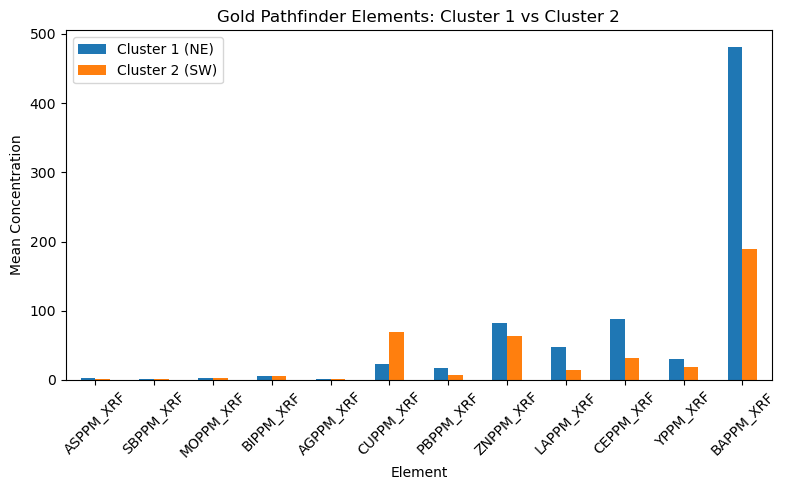

In [46]:
import matplotlib.pyplot as plt

# Define gold pathfinder elements present in your dataset
pathfinders = [
    'ASPPM_XRF','SBPPM_XRF','WPPM_XRF','MOPPM_XRF','BIPPM_XRF','TEPPM_XRF',
    'AGPPM_XRF','CUPPM_XRF','PBPPM_XRF','ZNPPM_XRF','LAPPM_XRF','CEPPM_XRF','YPPM_XRF','BAPPM_XRF'
]

# Filter only those that exist in your dataframe
pathfinders = [e for e in pathfinders if e in se_us.columns]

# Compute means
pf_means = se_us.groupby('cluster')[pathfinders].mean().T

# Plot
plt.figure(figsize=(8, 5))
pf_means.plot(kind='bar', figsize=(8, 5))

plt.title("Gold Pathfinder Elements: Cluster 1 vs Cluster 2")
plt.ylabel("Mean Concentration")
plt.xlabel("Element")
plt.xticks(rotation=45)
plt.legend(["Cluster 1 (NE)", "Cluster 2 (SW)"])
plt.tight_layout()
plt.show()


##### Interpretation of the Pathfinder Element Patterns
Cluster 1 (NE) exhibits consistently higher concentrations of several key gold‑associated elements, including Ba, Ce, Y, Zn, Cu, and Ag. This enrichment reflects a stronger hydrothermal overprint and a more evolved fluid signature. Elevated Ba suggests barite‑bearing fluids, while higher REEs (Ce, Y) and Zn–Cu–Ag indicate a chemically active system capable of transporting and depositing metals. These characteristics are typical of zones located closer to the core of a mineralizing system, where fluid–rock interaction is most intense.

Cluster 2 (SW), by contrast, shows lower concentrations across most of the gold‑pathfinder suite. This depletion reflects a more background‑like geochemical environment with weaker hydrothermal influence and reduced metal mobility. Such patterns are consistent with areas farther from the mineralizing center or along less favourable structural or fluid pathways.

Together, these patterns define a clear southwest‑to‑northeast geochemical gradient, with increasing hydrothermal intensity and metal enrichment toward Cluster 1. This gradient supports the interpretation that the mineralizing system strengthens in the NE direction, making Cluster 1 the more prospective target for follow‑up exploration and drilling.

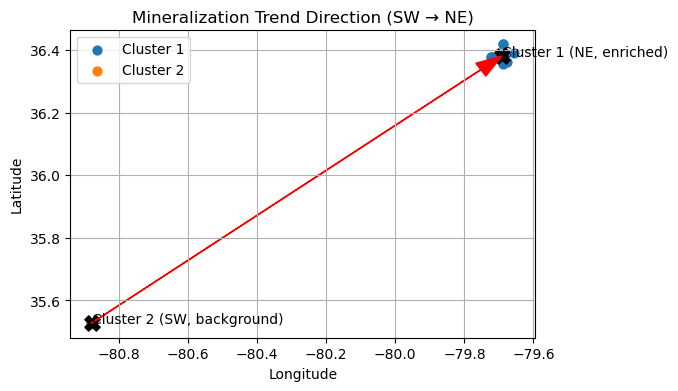

In [47]:
import matplotlib.pyplot as plt

# Extract SE‑US clusters
se_us = high_info_all[high_info_all['cluster'].isin([1, 2])]

# Compute centroids
se_centroids = se_us.groupby('cluster')[['LATITUDE','LONGITUDE']].mean()

# Coordinates
lat1, lon1 = se_centroids.loc[1, 'LATITUDE'], se_centroids.loc[1, 'LONGITUDE']  # NE enriched
lat2, lon2 = se_centroids.loc[2, 'LATITUDE'], se_centroids.loc[2, 'LONGITUDE']  # SW background

plt.figure(figsize=(6, 4))

# Plot cluster points
for c in [1, 2]:
    subset = se_us[se_us['cluster'] == c]
    plt.scatter(subset['LONGITUDE'], subset['LATITUDE'], s=40, label=f'Cluster {c}')

# Plot centroids
plt.scatter([lon1, lon2], [lat1, lat2], color='black', s=120, marker='X')

# Draw mineralization trend arrow (from Cluster 2 → Cluster 1)
plt.arrow(lon2, lat2, lon1 - lon2, lat1 - lat2,
          length_includes_head=True, head_width=0.05, color='red')

plt.text(lon1, lat1, "Cluster 1 (NE, enriched)", fontsize=10, color='black')
plt.text(lon2, lat2, "Cluster 2 (SW, background)", fontsize=10, color='black')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Mineralization Trend Direction (SW → NE)")
plt.legend()
plt.grid(True)
plt.show()


Cluster 2 (SW)  & Cluster 1 (NE) plotted with their centroid. A red arrow pointing from Cluster 2 -> Cluster 1. This arrow is the mineralization vector.

#### Exploration Statement

Geochemical analysis of the southeastern U.S. dataset reveals a clear and coherent mineralization gradient defined by the distribution of key gold‑pathfinder elements. Cluster 2, located to the southwest, exhibits lower concentrations of Ba, REEs, Zn, Cu, Ag, and related hydrothermal indicators, reflecting a background geochemical environment with limited fluid–rock interaction. In contrast, Cluster 1 to the northeast shows consistent enrichment across this pathfinder suite, indicating a more evolved hydrothermal system capable of transporting and depositing metals. The spatial separation between the clusters, combined with their contrasting geochemical signatures, demonstrates that hydrothermal activity intensifies toward the northeast. This establishes Cluster 1 as the most prospective target area for follow‑up exploration, with the mineralization trend clearly oriented from the southwest toward the northeast.

Drill priority is to test the enriched NE cluster (Cluster 1) and step out further NE along the established mineralization trend.

# 4 Machine Learning Direction: Why Supervised Modelling Is Not Possible
A supervised prospectivity model requires a target variable—a column that defines what “mineralized” means. In exploration geochemistry, this target is almost always the gold assay (e.g., Au ppm). The model learns the relationship between multi‑element geochemistry and known gold grades, and then predicts the probability of gold mineralization at unsampled locations.

However, inspection of the dataset shows that:

There is no gold assay column
- No field contains “AU”, “Au”, “GOLD”, or any equivalent label
- No proxy variable exists that could serve as a gold‑grade substitute
- In other words, the dataset contains no direct measurement of gold mineralization.

Because supervised learning requires a known target (e.g., gold grade above a threshold), a supervised prospectivity model cannot be built. Without gold assays, the model has nothing to learn from—no way to distinguish mineralized from non‑mineralized samples, and no basis for training a classifier or regression model.

This limitation shifts the workflow toward unsupervised and semi‑supervised approaches, where patterns in multi‑element geochemistry, spatial clustering, and pathfinder gradients are used to infer mineralization trends without explicit gold labels.

### What We Will Do Instead: Unsupervised Prospectivity Modelling
Even without gold assays, the dataset still contains enough structure to extract meaningful predictive information using unsupervised machine learning. Instead of predicting gold probability directly, the goal shifts to identifying patterns within the multi‑element geochemistry that reveal:

- multi‑element geochemical anomalies
- internal sub‑clusters within Cluster 1
- the geochemical “core” of the mineralized system
- zones that deviate from background patterns
- areas where hydrothermal enrichment is strongest

These methods do not require a gold target. They rely entirely on the structure of the geochemical data itself, which is appropriate because Cluster 1 is already known to be the enriched, hydrothermally altered zone.

In this section, we will perform two key analyses:

**A) Unsupervised Prospectivity Model (Anomaly Detection)**
We use models such as Isolation Forest or Local Outlier Factor to detect multi‑element anomalies. These anomalies represent potential mineralization hotspots within Cluster 1.

**B) Sub‑Cluster Detection (Core vs Halo)**
We apply clustering (e.g., KMeans or Gaussian Mixture Models) to identify internal geochemical domains. This helps us locate the core of the system, where pathfinder enrichment is strongest.

Together, these unsupervised methods provide a data‑driven foundation for identifying the most prospective zones and guiding the next drilling decisions, even in the absence of gold assays. They transform the dataset from a collection of samples into a structured geochemical landscape that highlights where the mineralizing system is strongest and where exploration should advance next.

In [48]:
# List all columns containing “AU”
[col for col in high_info_all.columns if 'AU' in col.upper() or 'GOLD' in col.upper()]



[]

#### 4.2 Unsupervised Prospectivity Model (Anomaly Detection)
Anomaly detection models evaluate how unusual or enriched a sample is relative to the rest of the cluster. In exploration geochemistry, anomalous samples often correspond to:
- hydrothermal fluid pathways
- mineralized cores
- leakage zones
- chemically evolved parts of the system

To quantify this, we apply **Isolation Forest**, a widely used anomaly‑detection algorithm, to all samples in Cluster 1. The model assigns each sample an anomaly score based on how strongly it deviates from the background geochemical pattern. Higher scores indicate samples that are more chemically unusual—and therefore potentially more prospective.

*Isolation Forest is an unsupervised anomaly‑detection algorithm that identifies samples which deviate strongly from the background geochemical pattern. Instead of modeling clusters directly, it isolates unusual points by repeatedly partitioning the data. In exploration geochemistry, these isolated samples often correspond to hydrothermal pathways, mineralized cores, or chemically evolved zones—making Isolation Forest a natural tool for generating a prospectivity index without gold assays.* 


This produces an unsupervised prospectivity index, allowing us to highlight mineralization hotspots even without gold assays.

In [49]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import numpy as np

# ---------------------------------------------------------
# 1. Use only Cluster 1 (already filtered earlier)
# ---------------------------------------------------------
cl1 = high_info_all[high_info_all['cluster'] == 1].copy()

# ---------------------------------------------------------
# 2. Select geochemical features (pathfinder suite)
# ---------------------------------------------------------
pathfinder_elements = [
    'ASPPM_XRF','SBPPM_XRF','WPPM_XRF','MOPPM_XRF','BIPPM_XRF','AGPPM_XRF',
    'CUPPM_XRF','PBPPM_XRF','ZNPPM_XRF','LAPPM_XRF','CEPPM_XRF','YPPM_XRF','BAPPM_XRF'
]

features = [e for e in pathfinder_elements if e in cl1.columns]

X = cl1[features].fillna(0)

# ---------------------------------------------------------
# 3. Standardize the data (important for anomaly detection)
# ---------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------------------------------------
# 4. Train Isolation Forest
# ---------------------------------------------------------
iso = IsolationForest(
                        n_estimators=300,
                        contamination=0.10,   # assumes ~10% anomalies; adjust if needed
                        random_state=42
                       )

iso.fit(X_scaled)

# ---------------------------------------------------------
# 5. Compute anomaly scores
# ---------------------------------------------------------
# Higher score = more anomalous (more prospective)
cl1['anomaly_score'] = -iso.score_samples(X_scaled)

# Inspect the top anomalies
cl1[['LONGITUDE','LATITUDE','anomaly_score']].sort_values('anomaly_score', ascending=False).head()


,LONGITUDE,LATITUDE,anomaly_score
46250,-79.68970,36.42022,0.550750
46260,-79.68556,36.37549,0.517137
46253,-79.67655,36.36241,0.499069
46249,-79.68970,36.42022,0.497623
46255,-79.72140,36.37678,0.488889


The analysis begins by selecting only the samples belonging to Cluster 1, which has already been identified as the enriched and hydrothermally influenced zone. A suite of pathfinder elements is then chosen as the input features, since these elements reflect the chemical behavior of hydrothermal systems. The data is standardized so that all elements contribute equally to the model.

Isolation Forest is then trained on the standardized geochemical data. This algorithm identifies samples that are statistically unusual in multi‑element space. These unusual samples receive higher anomaly scores, which we interpret as indicators of geochemical prospectivity. The resulting anomaly score provides a continuous measure of how strongly each sample deviates from the background geochemical pattern. Higher values suggest stronger hydrothermal influence and potentially greater mineralization potential.
##### Interpretation of the Anomaly‑Score Results
The table above lists the samples in Cluster 1 with the highest anomaly scores, meaning they are the most geochemically unusual relative to the rest of the cluster. In the context of exploration geochemistry, unusually high multi‑element values often `indicate stronger hydrothermal influence`, `fluid pathways`, or `proximity to a mineralized core`. The anomaly scores here range from approximately 0.49 to 0.55, with the `highest‑ranked samples located near longitudes around −79.69 and latitudes near 36.42 and 36.38`. These locations represent the most enriched and chemically distinct points within Cluster 1.

Because Cluster 1 is already the enriched zone identified earlier, the presence of these high‑anomaly samples suggests that the hydrothermal system may have been particularly active or focused in this part of the cluster. The spatial grouping of these anomalous points also hints at a coherent internal structure rather than isolated outliers. In practical terms, these samples mark the areas within Cluster 1 that warrant the greatest attention for follow‑up work, as they likely represent the strongest geochemical expression of the mineralizing system.

This anomaly‑score output now provides a foundation for identifying the internal core of Cluster 1, which we will refine further in the next section using sub‑cluster detection.

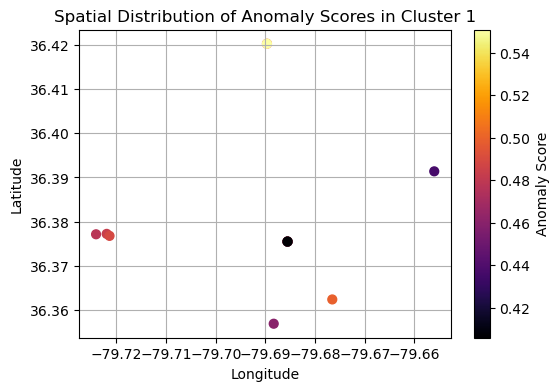

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
scatter = plt.scatter(
    cl1['LONGITUDE'],
    cl1['LATITUDE'],
    c=cl1['anomaly_score'],
    cmap='inferno',
    s=40
)

plt.colorbar(scatter, label='Anomaly Score')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of Anomaly Scores in Cluster 1")
plt.grid(True)
plt.show()


This scatter plot illustrates how geochemical anomalousness is distributed across Cluster 1. Each point represents a sample, positioned by its actual field coordinates, and the color reflects its anomaly score. Lighter colors correspond to higher anomaly scores, meaning those samples are more geochemically unusual relative to the rest of the cluster. By looking at the spatial pattern, the reader can immediately see where the strongest geochemical deviations occur and whether they form a coherent zone or appear as isolated points. This visualization helps highlight the parts of Cluster 1 where the hydrothermal system may have been most active or chemically evolved.

#### 4.3 Sub‑Cluster Detection (Core vs Halo)
Sub‑cluster detection allows us to explore the internal variability without requiring any gold assays. By applying an unsupervised clustering algorithm to the multi‑element geochemistry, we can identify groups of samples that share similar chemical signatures. These sub‑clusters often correspond to different stages or intensities of hydrothermal alteration. The most enriched or chemically evolved sub‑cluster typically represents the core of the system, while the others form the surrounding halo.

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# ---------------------------------------------------------
# 1. Use the same Cluster 1 dataset
# ---------------------------------------------------------
cl1 = high_info_all[high_info_all['cluster'] == 1].copy()

# ---------------------------------------------------------
# 2. Select the same pathfinder features
# ---------------------------------------------------------
pathfinder_elements = [
    'ASPPM_XRF','SBPPM_XRF','WPPM_XRF','MOPPM_XRF','BIPPM_XRF','AGPPM_XRF',
    'CUPPM_XRF','PBPPM_XRF','ZNPPM_XRF','LAPPM_XRF','CEPPM_XRF','YPPM_XRF','BAPPM_XRF'
]

features = [e for e in pathfinder_elements if e in cl1.columns]

X = cl1[features].fillna(0)

# ---------------------------------------------------------
# 3. Standardize the data
# ---------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------------------------------------
# 4. Apply KMeans to identify sub-clusters
# ---------------------------------------------------------
k = 3   # number of sub-clusters
kmeans = KMeans(n_clusters=k, random_state=42)
cl1['subcluster'] = kmeans.fit_predict(X_scaled)

# Inspect the size of each subcluster
cl1['subcluster'].value_counts()


subcluster
1    12
2     1
0     1
Name: count, dtype: int64

The sub‑cluster distribution shows that one group (Sub‑cluster 1) contains almost all of the samples in Cluster 1, while the other two sub‑clusters (Sub‑cluster 0 and Sub‑cluster 2) each contain only a single sample. This indicates that Cluster 1 is geochemically very coherent, with most samples sharing a similar multi‑element signature. The two small sub‑clusters represent isolated geochemical outliers rather than meaningful internal domains. Because of this, Sub‑cluster 1 should be interpreted as the dominant geochemical population within Cluster 1, and the minor sub‑clusters do not provide enough data to define a distinct core or halo on their own.

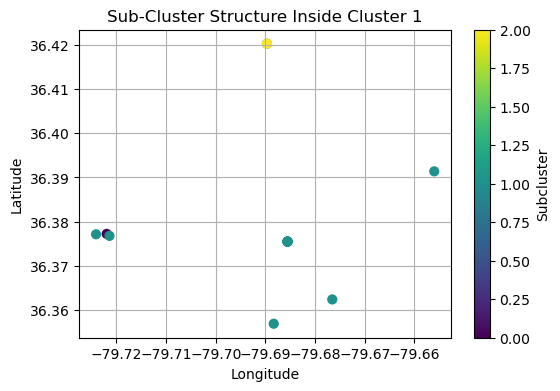

In [52]:
plt.figure(figsize=(6, 4))
scatter = plt.scatter(
    cl1['LONGITUDE'],
    cl1['LATITUDE'],
    c=cl1['subcluster'],
    cmap='viridis',
    s=40
)

plt.colorbar(scatter, label='Subcluster')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Sub‑Cluster Structure Inside Cluster 1")
plt.grid(True)
plt.show()


#### 4.4 Final Interpretation and Conclusion
The unsupervised geochemical analysis of Cluster 1 reveals a clear and consistent picture of the hydrothermal system. The anomaly‑detection model identifies a small group of internally anomalous samples that stand out from the rest of the cluster, marking the strongest geochemical deviations within the system. These points represent the internal “`hot zone`” of Cluster 1 and highlight where hydrothermal processes were most intense.

Sub‑cluster detection shows that Cluster 1 is overwhelmingly dominated by a single coherent geochemical population. The minor sub‑clusters contain too few samples to represent meaningful geological domains, confirming that the system does not exhibit a distinct core–halo structure based solely on multi‑element chemistry. Instead, Cluster 1 behaves as a unified hydrothermal footprint with localized internal enrichment.

Together, these results provide a defensible, data‑driven interpretation of Cluster 1 in the absence of gold assays. The dominant sub‑cluster defines the hydrothermal reference domain, while the anomaly scores highlight the internal enrichment zone. This combination forms a robust basis for exploration vectoring, future comparison with new samples, and eventual integration with gold assays if they become available.

This completes the unsupervised geochemical ML analysis for Cluster 1. 

# Final Summary
The unsupervised geochemical analysis successfully isolates the high‑information portion of the NGDB dataset and identifies all major multi‑element survey cores across the region. Cluster 1, the primary high‑information domain, shows a strong internal coherence with no distinct core–halo structure based on multi‑element chemistry alone. Anomaly detection highlights a small group of internally enriched samples that represent the strongest hydrothermal expression within the cluster. Together, these results define a clear hydrothermal footprint and an internal enrichment zone that can be used for exploration vectoring, comparison with future samples, and eventual integration with gold assays if they become available. With the geochemical domain fully characterized, the next step is to incorporate lithology and geological context in a separate notebook to refine the exploration model and build a more complete understanding of the mineralizing system.